# Objective
* 20200502: 
    * Given daily returns for the last N days, we do prediction for the next N+H days, where H is the forecast horizon
    * Using xgboost

In [1]:
pip install chart_studio

     |████████████████████████████████| 64 kB 2.1 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=76a4ed9aada17ac2527026c1697e518091ea191459537bafda1166ffcecabab1
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [2]:
import chart_studio.plotly as py
import math
import matplotlib
import numpy as np
import pandas as pd
import pickle
import pylab
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.offline as pyo
import scipy.stats as stats
import time

from collections import defaultdict
from datetime import date
from fastai.tabular import add_datepart
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

pyo.init_notebook_mode()

py.sign_in('starlord22', '7SNQrcP0a4ChRsvVSoUH') # sign in to plotly if you haven't done so

Output hidden; open in https://colab.research.google.com to view.

In [3]:
! gdown --id 1avhHiZ64kXn-XdhA7AvcqlI2_gZTHNhR

Downloading...
From: https://drive.google.com/uc?id=1avhHiZ64kXn-XdhA7AvcqlI2_gZTHNhR
To: /content/VTI_20130102_20181231.csv
100% 109k/109k [00:00<00:00, 44.2MB/s]


In [4]:
import pandas as pd

df1 = pd.read_csv ('VTI_20130102_20181231.csv')
display(df1.head())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,74.529999,75.150002,74.500000,75.139999,66.997757,5037200
1,2013-01-03,75.120003,75.370003,74.839996,75.029999,66.899689,2634600
2,2013-01-04,75.139999,75.519997,74.989998,75.410004,67.238510,2512900
3,2013-01-07,75.180000,75.279999,74.949997,75.209999,67.060173,2511200
4,2013-01-08,75.110001,75.180000,74.699997,75.010002,66.881859,1407900


In [5]:
# Predicting on day 1008, date 2017-01-03 00:00:00
# Predicting on day 1050, date 2017-03-06 00:00:00
# Predicting on day 1092, date 2017-05-04 00:00:00
# Predicting on day 1134, date 2017-07-05 00:00:00
# Predicting on day 1176, date 2017-09-01 00:00:00
# Predicting on day 1218, date 2017-11-01 00:00:00
# Predicting on day 1260, date 2018-01-03 00:00:00
# Predicting on day 1302, date 2018-03-06 00:00:00
# Predicting on day 1344, date 2018-05-04 00:00:00
# Predicting on day 1386, date 2018-07-05 00:00:00
# Predicting on day 1428, date 2018-09-04 00:00:00
# Predicting on day 1470, date 2018-11-01 00:00:00

pred_day = 1470                # Predict for this day, for the next H-1 days. Note indexing of days start from 0.

H = 21                         # Forecast horizon, in days. Note there are about 252 trading days in a year
train_size = 252*3             # Use 3 years of data as train set. Note there are about 252 trading days in a year
val_size = 252                 # Use 1 year of data as validation set
N = 10                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

# Plotly colors
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 1008


In [6]:
tic1 = time.time()

# Common functions

In [7]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_wape(y_true, y_pred): 
    """
    Compute weighted absolute percentage error (WAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return sum(np.abs(y_true - y_pred)) / sum(y_true) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

In [8]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out



def add_lags(df, N, lag_cols):
    """
    Add lags up to N number of days to use as features
    The lag columns are labelled as 'adj_close_lag_1', 'adj_close_lag_2', ... etc.
    """
    # Use lags up to N number of days to use as features
    df_w_lags = df.copy()
    df_w_lags.loc[:, 'order_day'] = [x for x in list(range(len(df)))] # Add a column 'order_day' to indicate the order of the rows by date
    merging_keys = ['order_day'] # merging_keys
    shift_range = [x+1 for x in range(N)]
    for shift in shift_range:
        train_shift = df_w_lags[merging_keys + lag_cols].copy()
    
        # E.g. order_day of 0 becomes 1, for shift = 1.
        # So when this is merged with order_day of 1 in df_w_lags, this will represent lag of 1.
        train_shift['order_day'] = train_shift['order_day'] + shift
    
        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        df_w_lags = pd.merge(df_w_lags, train_shift, on=merging_keys, how='left') #.fillna(0)
    del train_shift
    
    return df_w_lags

## pred_xgboost

In [9]:
def pred_xgboost(model, X_test_ex_lags, N, H, prev_targets):
    """
    Do recursive forecasting using xgboost
    Inputs
        model              : the xgboost model
        X_test_ex_lags     : features of the test set, excluding the daily_ret lags
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        prev_targets       : numpy array. If predicting daily_ret at time t, 
                             prev_targets will contain the N daily_ret values at t-1, t-2, ..., t-N
    Outputs
        Times series of predictions. Numpy array of shape (H,). This is unscaled.
    """
    forecast = prev_targets.copy()

    for n in range(H):
        
        # Create the features dataframe
        X = X_test_ex_lags[n:n+1].copy()
        for n in range(N,0,-1):
            X['daily_ret_lag_'+str(n)] = [forecast[-n]]
        X = pd.DataFrame(X)
             
        # Do prediction
        est = model.predict(X)
        
        # Concatenate the prediction
        forecast = np.concatenate([forecast, est])
           
    return forecast[-H:]

## train_pred_eval_model

In [10]:
def train_pred_eval_model(X_train,
                          y_train,
                          X_test_ex_lags,
                          y_test_adj_close,
                          prev_val,
                          prev_targets,
                          N,
                          H,
                          seed=100,
                          n_estimators=100,
                          max_depth=3,
                          learning_rate=0.1,
                          min_child_weight=1,
                          subsample=1,
                          colsample_bytree=1,
                          colsample_bylevel=1,
                          gamma=0):
    '''
    Train model, do prediction, and do evaluation
    Use XGBoost here.
    Inputs
        X_train            : features for training
        y_train            : target for training
        X_test_ex_lags     : features of the test set, excluding the daily_ret lags
        y_test_adj_close   : target for test. This is adjusted close, not daily returns
        prev_val           : if predict at time t, this is the adj_close value at t-1
        prev_targets       : numpy array. If predicting daily_ret at time t, 
                             prev_targets will contain the N daily_ret values at t-1, t-2, ..., t-N
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        mae                : mean absolute error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(objective ='reg:squarederror',
                         seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
        
    # Train the model
    model.fit(X_train, y_train)
     
    # Get predicted labels and scale back to original range
    est = pred_xgboost(model, X_test_ex_lags, N, H, prev_targets)
    
    # Convert back to price
    est_adj_close = []
    for n in range(H):
        prev_val = (est[n]/100+1)*prev_val
        est_adj_close.append(prev_val)

    # Calculate RMSE, MAPE, MAE
    rmse = get_rmse(y_test_adj_close, est_adj_close)
    mape = get_mape(y_test_adj_close, est_adj_close)
    mae = get_mae(y_test_adj_close, est_adj_close)
    
    return rmse, mape, mae, est_adj_close, model.feature_importances_


## get_error_metrics

In [11]:
def get_error_metrics(df,
                      train_size,
                      target,
                      N,
                      H,
                      seed=100,
                      n_estimators=100,
                      max_depth=3,
                      learning_rate=0.1,
                      min_child_weight=1,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      gamma=0):
    """
    Given a series consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                 : train + val dataframe. len(df) = train_size + val_size
        train_size         : size of train set
        target             : e.g. 'daily_ret'
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 

    Outputs
        mean of rmse, mean of mape, mean of mae, dictionary of predictions
    """
    rmse_list = [] # root mean square error
    mape_list = [] # mean absolute percentage error
    mae_list = []  # mean absolute error
    preds_dict = {}
    
    # Add lags up to N number of days to use as features
    df = add_lags(df, N, [target])
    
    # Get list of features
    features_ex_lags = [
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end'
    ]
    features = features_ex_lags # features contain all features, including lag features
    for n in range(N,0,-1):
        features.append(target+"_lag_"+str(n))
    
    for i in range(train_size, len(df)-H+1, int(H/2)):
        
        # Split into train and test
        train = df[i-train_size:i].copy()
        test = df[i:i+H].copy()
    
        # Drop the NaNs in train
        train.dropna(axis=0, how='any', inplace=True)
    
        # Split into X and y
        X_train = train[features]
        y_train = train[target]
        X_test_ex_lags = test[features_ex_lags]
        y_test_adj_close = test['adj_close']
        prev_val = float(train['adj_close'][-1:])
        prev_targets = train[-N:][target].to_numpy()
            
        rmse, mape, mae, est, feature_importances = train_pred_eval_model(X_train,
                                                        y_train,
                                                        X_test_ex_lags,
                                                        y_test_adj_close,
                                                        prev_val,
                                                        prev_targets,
                                                        N,
                                                        H,
                                                        seed=seed,
                                                        n_estimators=n_estimators,
                                                        max_depth=max_depth,
                                                        learning_rate=learning_rate,
                                                        min_child_weight=min_child_weight,
                                                        subsample=subsample,
                                                        colsample_bytree=colsample_bytree,
                                                        colsample_bylevel=colsample_bylevel,
                                                        gamma=gamma)
#         print("N = " + str(N) + ", i = " + str(i) + ", rmse = " + str(rmse) + ", mape = " + str(mape) + ", mae = " + str(mae))
        
        rmse_list.append(rmse)
        mape_list.append(mape)
        mae_list.append(mae)
        preds_dict[i] = est
    
    return np.mean(rmse_list), np.mean(mape_list), np.mean(mae_list), preds_dict, feature_importances, features

## get_error_metrics_one_pred

In [12]:

# def get_error_metrics_one_pred(df,
#                                train_size,
#                                target,
#                                N,
#                                H,
#                                seed=100,
#                                n_estimators=100,
#                                max_depth=3,
#                                learning_rate=0.1,
#                                min_child_weight=1,
#                                subsample=1,
#                                colsample_bytree=1,
#                                colsample_bylevel=1,
#                                gamma=0):
#     """
#     Given a series consisting of both train+test, do one prediction of forecast horizon H on the test set.
#     Inputs
#         df                 : train + test dataframe. len(df) = train_size + test_size
#         train_size         : size of train set
#         target             : e.g. 'daily_ret'
#         N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
#         H                  : forecast horizon
#         seed               : model seed
#         n_estimators       : number of boosted trees to fit
#         max_depth          : maximum tree depth for base learners
#         learning_rate      : boosting learning rate (xgb’s “eta”)
#         min_child_weight   : minimum sum of instance weight(hessian) needed in a child
#         subsample          : subsample ratio of the training instance
#         colsample_bytree   : subsample ratio of columns when constructing each tree
#         colsample_bylevel  : subsample ratio of columns for each split, in each level
#         gamma              : 

#     Outputs
#         rmse, mape, mae, predictions
#     """    
#     # Add lags up to N number of days to use as features
#     df = add_lags(df, N, [target])
    
#     # Get list of features
#     features_ex_lags = [
#         'month',
#         'week',
#         'day',
#         'dayofweek',
#         'dayofyear',
#         'is_month_end',
#         'is_month_start',
#         'is_quarter_end',
#         'is_quarter_start',
#         'is_year_end'
#     ]
#     features = features_ex_lags # features contain all features, including lag features
#     for n in range(N,0,-1):
#         features.append(target+"_lag_"+str(n))
    
#     # Split into train and test
#     train = df[:train_size].copy()
#     test = df[train_size:train_size+H].copy()
    
#     # Drop the NaNs in train
#     train.dropna(axis=0, how='any', inplace=True)
        
#     # Split into X and y
#     X_train = train[features]
#     y_train = train[target]
#     X_test = test[features]
#     y_test_adj_close = test['adj_close']
#     prev_val = float(train['adj_close'][-1:])
            
#     rmse, mape, mae, est, feature_importances = train_pred_eval_model(X_train,
#                                                                       y_train,
#                                                                       X_test,
#                                                                       y_test_adj_close,
#                                                                       prev_val,
#                                                                       N,
#                                                                       H,
#                                                                       seed=seed,
#                                                                       n_estimators=n_estimators,
#                                                                       max_depth=max_depth,
#                                                                       learning_rate=learning_rate,
#                                                                       min_child_weight=min_child_weight,
#                                                                       subsample=subsample,
#                                                                       colsample_bytree=colsample_bytree,
#                                                                       colsample_bylevel=colsample_bylevel,
#                                                                       gamma=gamma)
    
#     return rmse, mape, mae, est, feature_importances, features

# Load data

In [13]:
df = pd.read_csv("VTI_20130102_20181231.csv", sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume
0,2013-01-02,74.529999,75.150002,74.500000,75.139999,66.997757,5037200
1,2013-01-03,75.120003,75.370003,74.839996,75.029999,66.899689,2634600
2,2013-01-04,75.139999,75.519997,74.989998,75.410004,67.238510,2512900
3,2013-01-07,75.180000,75.279999,74.949997,75.209999,67.060173,2511200
4,2013-01-08,75.110001,75.180000,74.699997,75.010002,66.881859,1407900
5,2013-01-09,75.190002,75.410004,75.110001,75.239998,67.086937,1421900
6,2013-01-10,75.620003,75.769997,75.220001,75.760002,67.550591,1403700
7,2013-01-11,75.760002,75.800003,75.510002,75.769997,67.559486,1248500
8,2013-01-14,75.750000,75.800003,75.440002,75.690002,67.488159,2745100
9,2013-01-15,75.400002,75.889999,75.339996,75.830002,67.612984,1109100


In [14]:
# Create returns column
df['daily_ret'] = 100.0 * ((df['adj_close'] / df['adj_close'].shift(1)) - 1)
df.head(10)

,date,open,high,low,close,adj_close,volume,daily_ret
0,2013-01-02,74.529999,75.150002,74.500000,75.139999,66.997757,5037200,NaN
1,2013-01-03,75.120003,75.370003,74.839996,75.029999,66.899689,2634600,-0.146375
2,2013-01-04,75.139999,75.519997,74.989998,75.410004,67.238510,2512900,0.506461
3,2013-01-07,75.180000,75.279999,74.949997,75.209999,67.060173,2511200,-0.265230
4,2013-01-08,75.110001,75.180000,74.699997,75.010002,66.881859,1407900,-0.265901
5,2013-01-09,75.190002,75.410004,75.110001,75.239998,67.086937,1421900,0.306627
6,2013-01-10,75.620003,75.769997,75.220001,75.760002,67.550591,1403700,0.691124
7,2013-01-11,75.760002,75.800003,75.510002,75.769997,67.559486,1248500,0.013168
8,2013-01-14,75.750000,75.800003,75.440002,75.690002,67.488159,2745100,-0.105577
9,2013-01-15,75.400002,75.889999,75.339996,75.830002,67.612984,1109100,0.184958


In [15]:
#df = df.dropna()

In [16]:
#df = df.reset_index(drop=True)

In [17]:
#df.head(10)

In [18]:
# Generate Gaussian curve to fit the daily returns
mu = df['daily_ret'].mean()
std = df['daily_ret'].std()
x = np.arange(df['daily_ret'].min(), df['daily_ret'].max(), 0.001)
y = [1/math.sqrt(2*math.pi)/std*math.exp(-((i-mu)**2)/2/(std**2)) for i in x]
gauss_df = pd.DataFrame({'x':x, 'y':y})
print("meam = " + str(mu) + ", std dev = " + str(std))

meam = 0.04543338844842785, std dev = 0.8134088128601792


Text(0, 0.5, 'probability density')

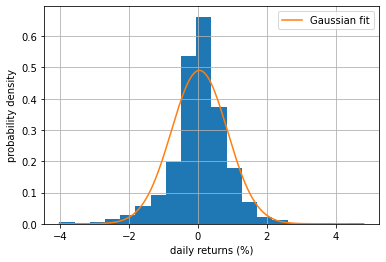

In [19]:
# Plot histogram of the daily returns
ax = df['daily_ret'].hist(bins=20, density=True)
gauss_df.plot(x='x', y='y', grid=True, ax=ax)
plt.legend(['Gaussian fit'])
plt.xlabel('daily returns (%)')
plt.ylabel('probability density')

In [20]:
fig = ff.create_distplot([np.array(df['daily_ret'][1:])], 
                         ['distplot'], 
                         bin_size=.2,
                         curve_type='normal', # override default 'kde'
                         )

# Add title
fig.update_layout(title_text='Distplot of daily returns with Normal Distribution')
fig.show()

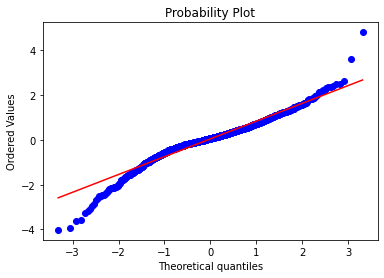

In [21]:
# Plot QQ plot
stats.probplot(df['daily_ret'][1:], dist="norm", plot=pylab)
pylab.show()

Looks mostly Gaussian, except for the extreme values

In [22]:
# Remove columns which you can't use as features
df.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)

In [23]:
# Plot with plotly
data = [go.Scatter(
            x = df['date'],
            y = df['adj_close'],
            mode = 'lines')]

layout = dict(xaxis = dict(title = 'date'),
              yaxis = dict(title = 'INR'))

fig = dict(data=data, layout=layout)
py.iplot(fig, filename="Lubs")

# Feature Engineering

In [24]:
#create features
add_datepart(df, 'date', drop=False)
df.drop('Elapsed', axis=1, inplace=True)  # don't need this
df.head(50)

/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:63: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.

/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:64: FutureWarning:

casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



,date,adj_close,daily_ret,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2013-01-02,66.997757,NaN,2013,1,1,2,2,2,False,False,False,False,False,False
1,2013-01-03,66.899689,-0.146375,2013,1,1,3,3,3,False,False,False,False,False,False
2,2013-01-04,67.238510,0.506461,2013,1,1,4,4,4,False,False,False,False,False,False
3,2013-01-07,67.060173,-0.265230,2013,1,2,7,0,7,False,False,False,False,False,False
4,2013-01-08,66.881859,-0.265901,2013,1,2,8,1,8,False,False,False,False,False,False
5,2013-01-09,67.086937,0.306627,2013,1,2,9,2,9,False,False,False,False,False,False
6,2013-01-10,67.550591,0.691124,2013,1,2,10,3,10,False,False,False,False,False,False
7,2013-01-11,67.559486,0.013168,2013,1,2,11,4,11,False,False,False,False,False,False
8,2013-01-14,67.488159,-0.105577,2013,1,3,14,0,14,False,False,False,False,False,False
9,2013-01-15,67.612984,0.184958,2013,1,3,15,1,15,False,False,False,False,False,False


In [25]:
# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

In [26]:
# Convert year to categorical feature, based on alphabetical order
df.loc[:, 'year'] = LabelEncoder().fit_transform(df['year'])
df.head()

,date,adj_close,daily_ret,year,month,week,day,dayofweek,dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
0,2013-01-02,66.997757,NaN,0,1,1,2,2,2,False,False,False,False,False,False
1,2013-01-03,66.899689,-0.146375,0,1,1,3,3,3,False,False,False,False,False,False
2,2013-01-04,67.238510,0.506461,0,1,1,4,4,4,False,False,False,False,False,False
3,2013-01-07,67.060173,-0.265230,0,1,2,7,0,7,False,False,False,False,False,False
4,2013-01-08,66.881859,-0.265901,0,1,2,8,1,8,False,False,False,False,False,False


# EDA

In [27]:
# Count number of nulls for each column
df.isnull().sum(axis=0)

date                0
adj_close           0
daily_ret           1
year                0
month               0
week                0
day                 0
dayofweek           0
dayofyear           0
is_month_end        0
is_month_start      0
is_quarter_end      0
is_quarter_start    0
is_year_end         0
is_year_start       0
dtype: int64

In [28]:
# Compute the average ret for each month
avg_ret_mth = df.groupby("month").agg({'daily_ret': 'mean'}).reset_index()

# Plot 
data = [go.Scatter(
            x = avg_ret_mth['month'],
            y = avg_ret_mth['daily_ret'],
            mode = 'markers',
            marker=dict(
                color='LightSkyBlue',
                size=15,
                line=dict(
                color='MediumPurple',
                width=2
                ))
        )]

layout = dict(xaxis = dict(title = 'month'),
              yaxis = dict(title = 'average daily return'))

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='StockReturnsPrediction_v3_avg_ret_mth')

In [29]:
# Compute the average daily return for each day of month
avg_ret_day = df.groupby("day").agg({'daily_ret': 'mean'}).reset_index()

# Plot 
data = [go.Scatter(
            x = avg_ret_day['day'],
            y = avg_ret_day['daily_ret'],
            mode = 'markers',
            marker=dict(
                color='LightSkyBlue',
                size=15,
                line=dict(
                color='MediumPurple',
                width=2
                ))
        )]

layout = dict(xaxis = dict(title = 'day of month'),
              yaxis = dict(title = 'average daily return'))

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='StockPricePrediction_v3_avg_ret_dayofmonth')

In [30]:
# Compute the average daily return for each day of week
avg_ret_dayofweek = df.groupby("dayofweek").agg({'daily_ret': 'mean'}).reset_index()

# Plot 
data = [go.Scatter(
            x = avg_ret_dayofweek['dayofweek'],
            y = avg_ret_dayofweek['daily_ret'],
            mode = 'markers',
            marker=dict(
                color='LightSkyBlue',
                size=15,
                line=dict(
                color='MediumPurple',
                width=2
                ))
        )]

layout = dict(xaxis = dict(title = 'day of week'),
              yaxis = dict(title = 'average daily return'))

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='StockReturnsPrediction_v3_avg_ret_dayofweek')

In [31]:
# Create lags 
df_lags = add_lags(df, N, ['daily_ret'])
df_lags

,date,adj_close,daily_ret,year,month,week,day,dayofweek,dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,order_day,daily_ret_lag_1,daily_ret_lag_2,daily_ret_lag_3,daily_ret_lag_4,daily_ret_lag_5,daily_ret_lag_6,daily_ret_lag_7,daily_ret_lag_8,daily_ret_lag_9,daily_ret_lag_10
0,2013-01-02,66.997757,NaN,0,1,1,2,2,2,False,False,False,False,False,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-03,66.899689,-0.146375,0,1,1,3,3,3,False,False,False,False,False,False,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-04,67.238510,0.506461,0,1,1,4,4,4,False,False,False,False,False,False,2,-0.146375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-07,67.060173,-0.265230,0,1,2,7,0,7,False,False,False,False,False,False,3,0.506461,-0.146375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-08,66.881859,-0.265901,0,1,2,8,1,8,False,False,False,False,False,False,4,-0.265230,0.506461,-0.146375,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504,2018-12-21,122.768997,-2.124119,5,12,51,21,4,355,False,False,False,False,False,False,1504,-1.614167,-1.535630,-0.030701,-2.133407,-1.727460,-0.243004,0.570274,-0.022207,0.111193,-2.359584
1505,2018-12-24,119.699997,-2.499817,5,12,52,24,0,358,False,False,False,False,False,False,1505,-2.124119,-1.614167,-1.535630,-0.030701,-2.133407,-1.727460,-0.243004,0.570274,-0.022207,0.111193
1506,2018-12-26,125.459999,4.812032,5,12,52,26,2,360,False,False,False,False,False,False,1506,-2.499817,-2.124119,-1.614167,-1.535630,-0.030701,-2.133407,-1.727460,-0.243004,0.570274,-0.022207
1507,2018-12-27,126.589996,0.900683,5,12,52,27,3,361,False,False,False,False,False,False,1507,4.812032,-2.499817,-2.124119,-1.614167,-1.535630,-0.030701,-2.133407,-1.727460,-0.243004,0.570274


In [32]:
# Compute correlation
features = [
        'daily_ret',
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end',
        'is_year_start'
]
for n in range(N,0,-1):
    features.append("daily_ret_lag_"+str(n))
        
corr_matrix = df_lags[features].corr()
corr_matrix["daily_ret"].sort_values(ascending=False)

daily_ret           1.000000
is_month_start      0.028326
is_quarter_start    0.022563
daily_ret_lag_3     0.013938
daily_ret_lag_7     0.013390
dayofweek           0.012338
is_quarter_end      0.009153
daily_ret_lag_10    0.000328
daily_ret_lag_6    -0.006594
week               -0.006747
month              -0.008775
daily_ret_lag_1    -0.009077
dayofyear          -0.009512
day                -0.009516
daily_ret_lag_5    -0.023214
is_month_end       -0.024595
daily_ret_lag_2    -0.025624
year               -0.030284
is_year_end        -0.031638
daily_ret_lag_8    -0.037644
daily_ret_lag_9    -0.040409
daily_ret_lag_4    -0.047849
is_year_start            NaN
Name: daily_ret, dtype: float64

In [33]:
# Plot correlation for lag features only
features = ['daily_ret']
for n in range(1,N+1,1):
    features.append("daily_ret_lag_"+str(n))
        
corr_matrix = df_lags[features].corr()

z_list = []
for feat in features:
    z_list.append(corr_matrix.loc[:, feat][features])

fig = go.Figure(data=go.Heatmap(
                   z=z_list,
                   x=features,
                   y=features))
py.iplot(fig, filename='StockReturnsPrediction_v3_corr_matrix_lags')

In [34]:
# Plot correlation for date features only
features = [
        'daily_ret',
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end',
        'is_year_start'
]
        
corr_matrix = df_lags[features].corr()

z_list = []
for feat in features:
    z_list.append(corr_matrix.loc[:, feat][features])

fig = go.Figure(data=go.Heatmap(
                   z=z_list,
                   x=features,
                   y=features))
py.iplot(fig, filename='StockReturnsPrediction_v3_corr_matrix_dates')

# Split into train, validation, test

In [35]:
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (pred_day, df.iloc[pred_day]['date'], H))

Predicting on day 1470, date 2018-11-01 00:00:00, with forecast horizon H = 21


In [36]:
train = df[pred_day-train_val_size:pred_day-val_size].copy()
val = df[pred_day-val_size:pred_day].copy()
train_val = df[pred_day-train_val_size:pred_day].copy()
test = df[pred_day:pred_day+H].copy()
print("train.shape = " + str(train.shape))
print("val.shape = " + str(val.shape))
print("train_val.shape = " + str(train_val.shape))
print("test.shape = " + str(test.shape))

train.shape = (756, 15)
val.shape = (252, 15)
train_val.shape = (1008, 15)
test.shape = (21, 15)


# Predict for a specific H (forecast horizon) and a specific date

In [37]:
# Get error metrics on validation set before hyperparameter tuning
rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning, preds_dict, _, _ = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        'daily_ret',
                                                                        N,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators,
                                                                        max_depth=max_depth,
                                                                        learning_rate=learning_rate,
                                                                        min_child_weight=min_child_weight,
                                                                        subsample=subsample,
                                                                        colsample_bytree=colsample_bytree,
                                                                        colsample_bylevel=colsample_bylevel,
                                                                        gamma=gamma)
print("RMSE = %0.3f" % rmse_bef_tuning)
print("MAPE = %0.3f%%" % mape_bef_tuning)
print("MAE = %0.3f" % mae_bef_tuning)

RMSE = 2.961
MAPE = 1.804%
MAE = 2.488


In [38]:
# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))

# Plot the predictions
n = 0
for key in preds_dict:
    fig.add_trace(go.Scatter(x=train_val[key:key+H]['date'], 
                             y=preds_dict[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))
fig.update_xaxes(range=[val['date'].min(), val['date'].max()])
fig.update_yaxes(range=[val['adj_close'].min(), val['adj_close'].max()])
py.iplot(fig, filename='StockPricePrediction_v3_xgboost_val_' + str(pred_day))

In [39]:
# Do prediction on test set
test_rmse_bef_tuning, test_mape_bef_tuning, test_mae_bef_tuning, preds_dict, feature_importances, features = \
                                            get_error_metrics(df[pred_day-train_val_size:pred_day+H],
                                                              train_size+val_size,
                                                              'daily_ret',
                                                              N,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators,
                                                              max_depth=max_depth,
                                                              learning_rate=learning_rate,
                                                              min_child_weight=min_child_weight,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)

print("RMSE = %0.3f" % test_rmse_bef_tuning)
print("MAPE = %0.3f%%" % test_mape_bef_tuning)
print("MAE = %0.3f" % test_mae_bef_tuning)

RMSE = 2.888
MAPE = 1.629%
MAE = 2.235


In [40]:
# Plot test predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))
fig.add_trace(go.Scatter(x=test[:H]['date'], 
                         y=preds_dict[list(preds_dict.keys())[0]],
                         mode='lines',
                         name='predictions',
                         line=dict(color='red')))
fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

In [41]:
# View a list of the features and their importance scores
imp = list(zip(features, feature_importances))
imp.sort(key=lambda tup: tup[1], reverse=False) 
imp

[('is_month_end', 0.0),
 ('is_month_start', 0.0),
 ('is_quarter_end', 0.0),
 ('is_quarter_start', 0.0),
 ('is_year_end', 0.0),
 ('dayofweek', 0.030435465),
 ('month', 0.032155056),
 ('week', 0.044140164),
 ('day', 0.048124693),
 ('dayofyear', 0.060994208),
 ('daily_ret_lag_10', 0.06292059),
 ('daily_ret_lag_9', 0.06468163),
 ('daily_ret_lag_1', 0.06514307),
 ('daily_ret_lag_7', 0.065419026),
 ('daily_ret_lag_8', 0.06853808),
 ('daily_ret_lag_3', 0.0785034),
 ('daily_ret_lag_2', 0.080029726),
 ('daily_ret_lag_6', 0.08102033),
 ('daily_ret_lag_5', 0.104951635),
 ('daily_ret_lag_4', 0.112943)]

# Predict for a specific H (forecast horizon) and a specific date, with hyperparam tuning

In [42]:
# We use a constant for N here
N_opt = N

## Tuning n_estimators (default=100) and max_depth (default=3)

In [43]:
param_label = 'n_estimators'
param_list = range(1, 61, 2)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _, _, _ = get_error_metrics(train_val,
                                                                    train_size,
                                                                    'daily_ret',
                                                                    N_opt,
                                                                    H,
                                                                    seed=model_seed,
                                                                    n_estimators=param,
                                                                    max_depth=param2,
                                                                    learning_rate=learning_rate,
                                                                    min_child_weight=min_child_weight,
                                                                    subsample=subsample,
                                                                    colsample_bytree=colsample_bytree,
                                                                    colsample_bylevel=colsample_bylevel,
                                                                    gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/30 [00:00<?, ?it/s]

Minutes taken = 10.59


,n_estimators,max_depth,rmse,mape,mae
0,1,2,7.848109,4.846767,6.720966
1,1,3,7.849775,4.847786,6.722561
2,1,4,7.836014,4.839115,6.709879
3,1,5,7.845536,4.844387,6.717835
4,1,6,7.846062,4.845561,6.719139
...,...,...,...,...,...
235,59,5,2.828374,1.727963,2.382471
236,59,6,3.013803,1.847349,2.549615
237,59,7,2.978747,1.799193,2.483706
238,59,8,2.952971,1.795640,2.479910


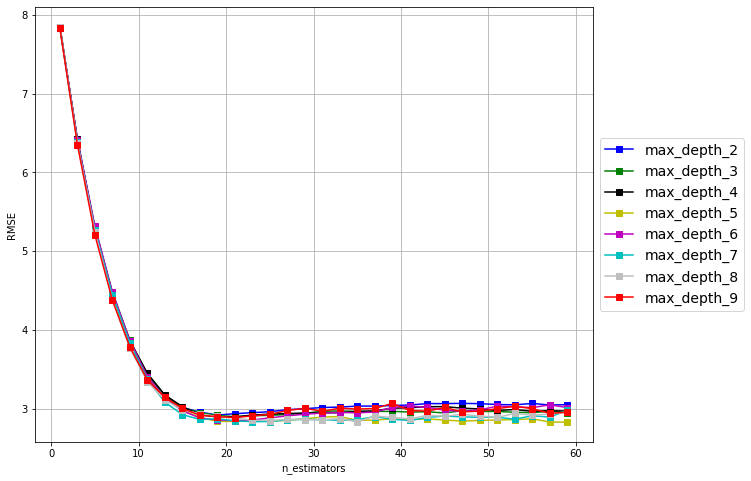

In [44]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 20])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [45]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 2.828
optimum params = 


(59, 5)

In [46]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 1.710%
optimum params = 


(23, 7)

## Tuning learning_rate(default=0.1) and min_child_weight(default=1)

In [47]:
param_label = 'learning_rate'
param_list = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _, _, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              'daily_ret',
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=param,
                                                              min_child_weight=param2,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/8 [00:00<?, ?it/s]

Minutes taken = 7.27


,learning_rate,min_child_weight,rmse,mape,mae
0,0.0001,5,8.657320,5.353267,7.426832
1,0.0001,6,8.657515,5.353327,7.426926
2,0.0001,7,8.657216,5.353204,7.426752
3,0.0001,8,8.657651,5.353488,7.427144
4,0.0001,9,8.657120,5.353193,7.426723
...,...,...,...,...,...
123,0.3000,16,3.142218,1.938090,2.673794
124,0.3000,17,3.471049,2.135301,2.957888
125,0.3000,18,3.383818,2.036490,2.812631
126,0.3000,19,3.407638,2.044282,2.818826


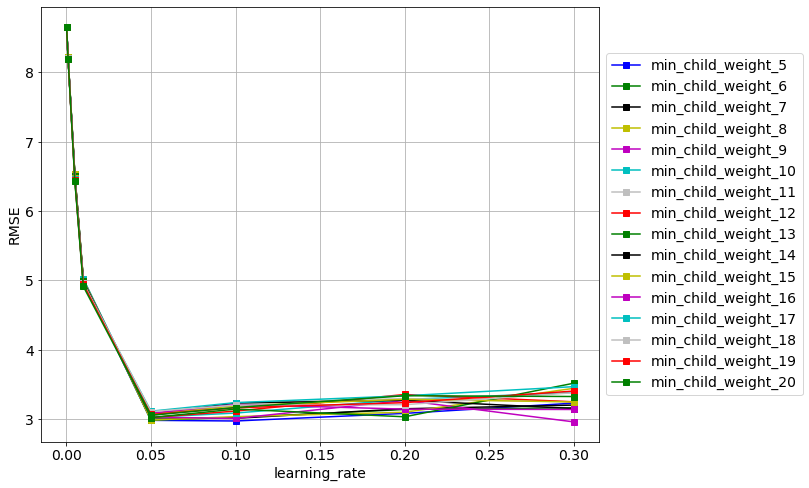

In [48]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 4])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [49]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 2.964
optimum params = 


(0.3, 9)

In [50]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 1.805%
optimum params = 


(0.3, 9)

## Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [51]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _, _, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              'daily_ret',
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=param,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=param2)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/10 [00:00<?, ?it/s]

Minutes taken = 5.83


,subsample,gamma,rmse,mape,mae
0,0.1,0.0,5.445923,3.376462,4.670465
1,0.1,0.1,5.098235,3.199319,4.432899
2,0.1,0.2,4.263631,2.668397,3.717894
3,0.1,0.3,4.955526,3.093410,4.272227
4,0.1,0.4,4.170887,2.598444,3.594828
...,...,...,...,...,...
105,1.0,0.6,3.164116,1.942217,2.674664
106,1.0,0.7,3.034709,1.844075,2.540180
107,1.0,0.8,3.094525,1.869607,2.574783
108,1.0,0.9,2.942360,1.799135,2.476427


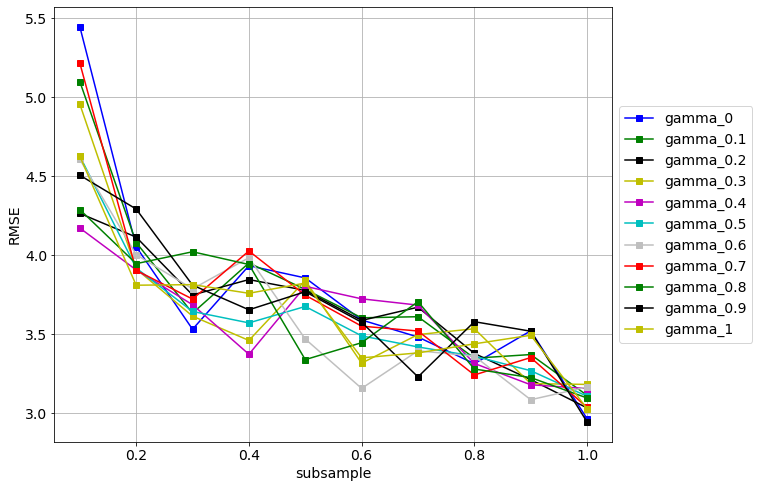

In [52]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [53]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 2.942
optimum params = 


(1.0, 0.9)

In [54]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 1.799%
optimum params = 


(1.0, 0.9)

## Tuning colsample_bytree(default=1) and colsample_bylevel(default=1)

In [55]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):    
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _, _, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              'daily_ret',
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=subsample_opt,
                                                              colsample_bytree=param,
                                                              colsample_bylevel=param2,
                                                              gamma=gamma_opt)

    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/6 [00:00<?, ?it/s]

Minutes taken = 1.68


,colsample_bytree,colsample_bylevel,rmse,mape,mae
0,0.5,0.5,3.343633,2.038986,2.815318
1,0.5,0.6,3.463780,2.115316,2.919545
2,0.5,0.7,3.286691,2.008641,2.777525
3,0.5,0.8,3.230939,1.958173,2.706738
4,0.5,0.9,3.149477,1.912484,2.641750
5,0.5,1.0,3.732486,2.311985,3.193747
6,0.6,0.5,3.523615,2.172017,2.999086
7,0.6,0.6,3.490864,2.127399,2.935360
8,0.6,0.7,3.499515,2.172277,3.001527
9,0.6,0.8,3.190275,1.959130,2.704911


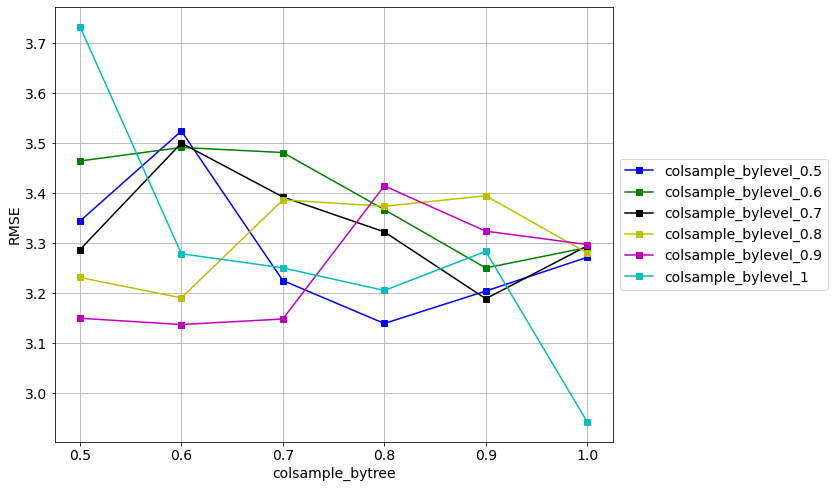

In [56]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [57]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 2.942
optimum params = 


(1.0, 1.0)

In [58]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 1.799%
optimum params = 


(1.0, 1.0)

## Final model

In [59]:
# Get error metrics on validation set after hyperparameter tuning
rmse_aft_tuning, mape_aft_tuning, mae_aft_tuning, preds_dict, _, _ = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        'daily_ret',
                                                                        N_opt,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators_opt,
                                                                        max_depth=max_depth_opt,
                                                                        learning_rate=learning_rate_opt,
                                                                        min_child_weight=min_child_weight_opt,
                                                                        subsample=subsample_opt,
                                                                        colsample_bytree=colsample_bytree_opt,
                                                                        colsample_bylevel=colsample_bylevel_opt,
                                                                        gamma=gamma_opt)
print("RMSE = %0.3f" % rmse_aft_tuning)
print("MAPE = %0.3f%%" % mape_aft_tuning)
print("MAE = %0.3f" % mae_aft_tuning)

RMSE = 2.942
MAPE = 1.799%
MAE = 2.476


In [60]:
# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))

# Plot the predictions
n = 0
for key in preds_dict:
    fig.add_trace(go.Scatter(x=train_val[key:key+H]['date'], 
                             y=preds_dict[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))
fig.update_xaxes(range=[val['date'].min(), val['date'].max()])
fig.update_yaxes(range=[val['adj_close'].min(), val['adj_close'].max()])
py.iplot(fig, filename='StockReturnsPrediction_v3_xgboost_val_aft_tune_'+str(pred_day))

In [61]:
# Do prediction on test set
test_rmse_aft_tuning, test_mape_aft_tuning, test_mae_aft_tuning, preds_dict, feature_importances, features = \
                                            get_error_metrics(df[pred_day-train_val_size:pred_day+H],
                                                                       train_size+val_size,
                                                                       'daily_ret',
                                                                       N_opt,
                                                                       H,
                                                                       seed=model_seed,
                                                                       n_estimators=n_estimators_opt,
                                                                       max_depth=max_depth_opt,
                                                                       learning_rate=learning_rate_opt,
                                                                       min_child_weight=min_child_weight_opt,
                                                                       subsample=subsample_opt,
                                                                       colsample_bytree=colsample_bytree_opt,
                                                                       colsample_bylevel=colsample_bylevel_opt,
                                                                       gamma=gamma_opt)


print("RMSE = %0.3f" % test_rmse_aft_tuning)
print("MAPE = %0.3f%%" % test_mape_aft_tuning)
print("MAE = %0.3f" % test_mae_aft_tuning)

RMSE = 2.756
MAPE = 1.552%
MAE = 2.135


In [62]:
# Plot test predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))
fig.add_trace(go.Scatter(x=test[:H]['date'], 
                         y=preds_dict[list(preds_dict.keys())[0]],
                         mode='lines',
                         name='predictions',
                         line=dict(color='red')))
fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

In [63]:
# View a list of the features and their importance scores
imp = list(zip(features, feature_importances))
imp.sort(key=lambda tup: tup[1], reverse=False) 
imp

[('is_month_end', 0.0),
 ('is_month_start', 0.0),
 ('is_quarter_end', 0.0),
 ('is_quarter_start', 0.0),
 ('is_year_end', 0.0),
 ('dayofyear', 0.057128947),
 ('daily_ret_lag_3', 0.057937097),
 ('daily_ret_lag_5', 0.058390297),
 ('month', 0.058939993),
 ('daily_ret_lag_8', 0.059133332),
 ('daily_ret_lag_1', 0.061796065),
 ('dayofweek', 0.06297104),
 ('week', 0.06371334),
 ('daily_ret_lag_7', 0.06403053),
 ('daily_ret_lag_6', 0.06514956),
 ('daily_ret_lag_10', 0.06762782),
 ('day', 0.067917116),
 ('daily_ret_lag_2', 0.069904566),
 ('daily_ret_lag_9', 0.08691909),
 ('daily_ret_lag_4', 0.09844112)]

In [64]:
# Plot the importance scores as a bar chart
fig = go.Figure(go.Bar(
            x=[item[1] for item in imp[-10:]],
            y=[item[0] for item in imp[-10:]],
            orientation='h'))
py.iplot(fig, filename='StockReturnsPrediction_v3_xgboost_imp_scores')

## Tuned params

In [65]:
# Tuned params and before and after error metrics
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'val_rmse', 'val_mape', 'val_mae'],
     'before_tuning': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, rmse_aft_tuning, mape_aft_tuning, mae_aft_tuning]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,before_tuning,after_tuning
0,n_estimators,100.000,59.000
1,max_depth,3.000,5.000
2,learning_rate,0.100,0.300
3,min_child_weight,1.000,9.000
4,subsample,1.000,1.000
5,colsample_bytree,1.000,1.000
6,colsample_bylevel,1.000,1.000
7,gamma,0.000,0.900
8,val_rmse,2.961,2.942
9,val_mape,1.804,1.799


In [66]:
file = open('./out/v3_tuned_params', 'wb')

In [166]:
# Put tuned_params into pickle
pickle.dump(tuned_params, open("./out/v3_tuned_params_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))

FileNotFoundError: ignored

In [ ]:
# pickle.load(open("./out/v6d_tuned_params_" + "2017-03-06" + ".pickle", "rb"))

In [ ]:
toc1 = time.time()
print("Total minutes taken = {0:.2f}".format((toc1-tic1)/60.0))

# Findings for a specific date

In [1]:
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (pred_day, df.iloc[pred_day]['date'].strftime("%Y-%m-%d"), H))

NameError: ignored

In [ ]:
rmse_bef_tuning, rmse_aft_tuning

In [ ]:
test_rmse_bef_tuning, test_rmse_aft_tuning

In [ ]:
# Put results into pickle
pickle.dump(rmse_bef_tuning, open("./out/v3_val_rmse_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(rmse_aft_tuning, open("./out/v3_val_rmse_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_rmse_bef_tuning, open("./out/v3_test_rmse_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mape_bef_tuning, open("./out/v3_test_mape_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mae_bef_tuning, open("./out/v3_test_mae_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_rmse_aft_tuning, open("./out/v3_test_rmse_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mape_aft_tuning, open("./out/v3_test_mape_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mae_aft_tuning, open("./out/v3_test_mae_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(preds_dict[list(preds_dict.keys())[0]], open("./out/v3_test_est_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))

# Findings across all dates

In [ ]:
# Consolidate results
# H = 21                         # Forecast horizon, in days. Note there are about 252 trading days in a year
# train_size = 252*3             # Use 3 years of data as train set. Note there are about 252 trading days in a year
# val_size = 252                 # Use 1 year of data as validation set
# N = 10                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
results = defaultdict(list)
ests = {} # the predictions
date_list = ['2017-01-03',
             '2017-03-06',
             '2017-05-04',
             '2017-07-05',
             '2017-09-01',
             '2017-11-01',
             '2018-01-03',
             '2018-03-06',
             '2018-05-04',
             '2018-07-05',
             '2018-09-04',
             '2018-11-01'
            ]
for date in date_list:
    results['date'].append(date)
    results['val_rmse_bef_tuning'].append(pickle.load(open( "./out/v3_val_rmse_bef_tuning_" + date + ".pickle", "rb")))
    results['val_rmse_aft_tuning'].append(pickle.load(open( "./out/v3_val_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results['test_rmse_bef_tuning'].append(pickle.load(open( "./out/v3_test_rmse_bef_tuning_" + date + ".pickle", "rb")))
    results['test_rmse_aft_tuning'].append(pickle.load(open( "./out/v3_test_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results['test_mape_bef_tuning'].append(pickle.load(open( "./out/v3_test_mape_bef_tuning_" + date + ".pickle", "rb")))
    results['test_mape_aft_tuning'].append(pickle.load(open( "./out/v3_test_mape_aft_tuning_" + date + ".pickle", "rb")))
    results['test_mae_bef_tuning'].append(pickle.load(open( "./out/v3_test_mae_bef_tuning_" + date + ".pickle", "rb")))
    results['test_mae_aft_tuning'].append(pickle.load(open( "./out/v3_test_mae_aft_tuning_" + date + ".pickle", "rb")))
    ests[date] = pickle.load(open( "./out/v3_test_est_aft_tuning_" + date + ".pickle", "rb"))
    
results = pd.DataFrame(results)
results

In [ ]:
# Generate a condensed dataframe of the above
results_short = defaultdict(list)
hyperparam_list = ['n_estimators', 
                   'max_depth', 
                   'learning_rate', 
                   'min_child_weight',
#                    'subsample',
#                    'colsample_bytree',
#                    'colsample_bylevel',
#                    'gamma'
                  ]

for date in date_list:
    results_short['date'].append(date)
    results_short['RMSE'].append(pickle.load(open( "./out/v3_test_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results_short['MAPE(%)'].append(pickle.load(open( "./out/v3_test_mape_aft_tuning_" + date + ".pickle", "rb")))
    results_short['MAE'].append(pickle.load(open( "./out/v3_test_mae_aft_tuning_" + date + ".pickle", "rb")))
    
    tuned_params = pickle.load(open("./out/v3_tuned_params_" + date + ".pickle", "rb"))
    for hyperparam in hyperparam_list:
        results_short[hyperparam].append(tuned_params[tuned_params['param']==hyperparam]['after_tuning'].values[0])

    
results_short = pd.DataFrame(results_short)
results_short

In [ ]:
results.mean()

In [ ]:
# Plot all predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['adj_close'],
                         mode='lines',
                         name='adj_close',
                         line=dict(color='blue')))

# Plot the predictions
n = 0
for key in ests:
    i = df[df['date']==key].index[0]
    fig.add_trace(go.Scatter(x=df[i:i+H]['date'], 
                             y=ests[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))
fig.update_xaxes(range=['2017-01-03', '2018-12-28'])
fig.update_yaxes(range=[110, 150])
py.iplot(fig, filename='StockPricePrediction_v3_xgboost_predictions')

In [ ]:
# Plot scatter plot of actual values vs. predictions
fig = go.Figure()

n = 0
for key in ests:
    i = df[df['date']==key].index[0]
    fig.add_trace(go.Scatter(x=df[i:i+H]['adj_close'], 
                             y=ests[key],
                             mode='markers',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.add_trace(go.Scatter(x=list(range(110, 155, 1)),
                         y=list(range(110, 155, 1)),
                         mode='lines',
                         name='actual values',
                         line=dict(color='blue')))

fig.update_layout(yaxis=dict(title='forecasts'),
                  xaxis=dict(title='adj_close'))
py.iplot(fig, filename='StockPricePrediction_v3_xgboost_actuals_vs_predictions')